In [2]:
from astropy.io import ascii
from astropy.table import Table

import numpy as np
import h5py

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.mplot3d import Axes3D

from scipy import spatial
from scipy.ndimage import label
from scipy.ndimage.filters import uniform_filter, gaussian_filter

from scipy import stats


import illustris_python as il
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from astropy import units as u

import tqdm

import pickle

In [3]:
basePath = './sims.TNG/TNG300-1/output/'

In [4]:
snaps_full = np.array([99, 91, 84, 78, 72, 67, 59, 50, 40, 33])
zs_full = np.array([0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.70, 1.00, 1.50, 2.00])
scale_factors = 1 / (1 + zs_full)
h = 0.704

In [5]:
def cal_fof(start, cands):
    
    check = np.full(len(cands), True, dtype = bool)
    
    f1mask = np.sqrt(np.sum((cands - start)**2, axis = 1)) <= 4
    f1_index = list(np.where(f1mask)[0])
    
    check[f1mask] = False
    
    if len(f1_index) == 0:
        return []
    
    new_index = []
    
    temp_index = []
    
    first = True
    
    while True:
        if first:
            first = False
            cand_index = f1_index.copy()
        else:
            cand_index = temp_index.copy()
            temp_index = []
            
        for j in range(len(cand_index)):
            f2mask = np.sqrt(np.sum((cands - cands[cand_index[j]])**2, axis = 1)) <= 4
            f2_index = np.where(f2mask & check)[0]
            
            check[f2_index] = False
            
            if len(f2_index) == 0:
                continue
            
            temp_index.extend(list(f2_index))
            
        new_index.extend(temp_index)
        
        if len(temp_index) ==0:
            break
    
    f1_index.extend(new_index)
    final_index = f1_index
    
    return final_index

In [6]:
SFRs = h5py.File('star_formation_rates.hdf5', 'r')

## QF in stellar mass bins

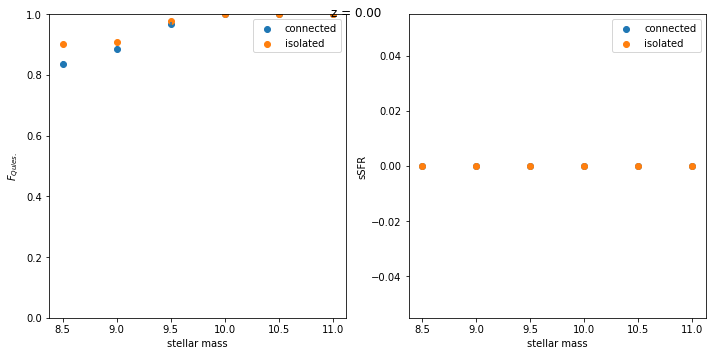

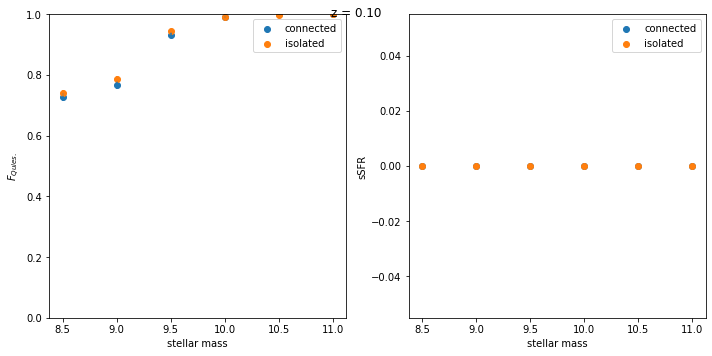

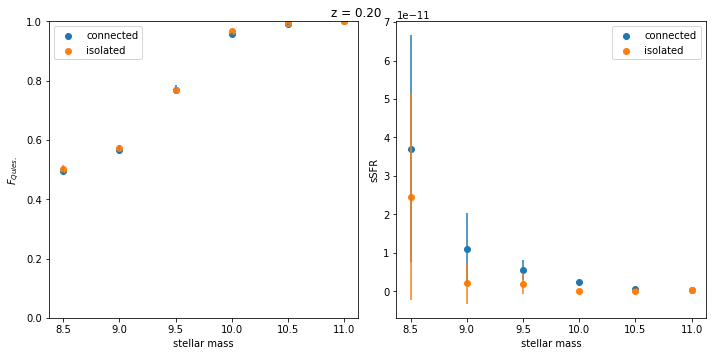

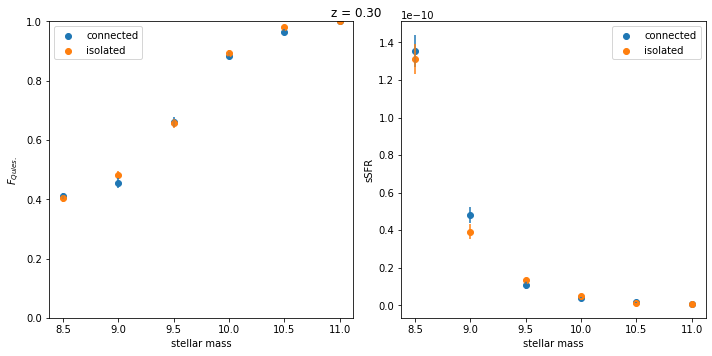

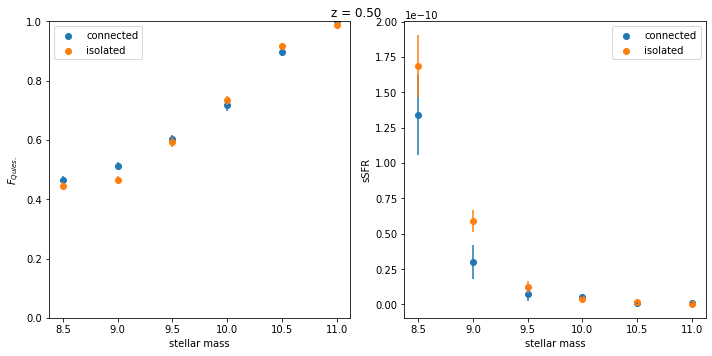

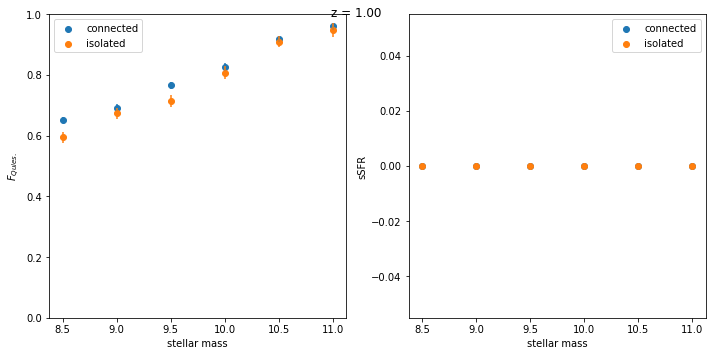

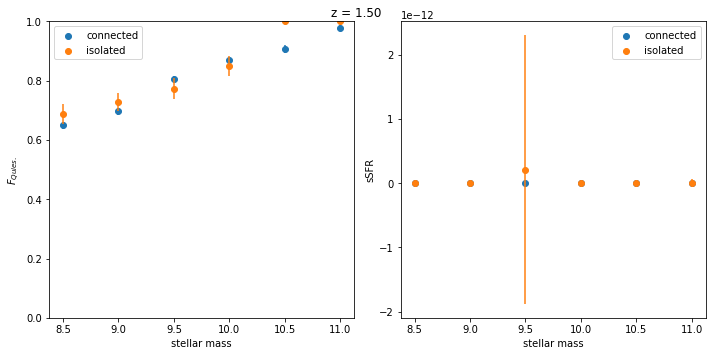

In [35]:
for isnap, snap in enumerate(snaps_full[:-1]):
    # isnap = np.where(snaps_full == snap)[0]

    scale_factor = scale_factors[isnap]
    z = zs_full[isnap]

    with h5py.File(f'./groups/grp_snap{snap}.hdf5', 'r') as f:
        #binning the grps in halo mass
        grp_m200 = f['Group_M_Crit200'][:] * 1e10 / 0.704
        grp_r200 = f['Group_R_Crit200'][:]
        grp_pos = f['GroupPos'][:]

    with h5py.File(f'./subhalos/subs_{snap}.hdf5', 'r') as f:
        MassInRad = f['SubhaloMassInRadType'][:, 4] * 1e10 / 0.704
        SubhaloGrNr = f['SubhaloGrNr'][:]
        SubhaloPos = f['SubhaloPos'][:]
        gal_mask = MassInRad >= 10**8.5

    halos = h5py.File(f'halo_structure_{snap:03d}.hdf5')

    with open(f'./lists_all/m200_snap{snap:03d}', "rb") as f:
        m200s = pickle.load(f)

    with open(f'./lists_all/mem_ids_snap{snap:03d}', "rb") as f:
        mem_ids = pickle.load(f)

    with open(f'./lists_all/mem_ids_twice_snap{snap:03d}', "rb") as f:
        mem_ids_twice = pickle.load(f)

    with open(f'./lists_all/fofs_snap{snap:03d}', "rb") as f:
        fofs = pickle.load(f)

    with open(f'./lists_all/fqs_snap{snap:03d}', "rb") as f:
        fqs = pickle.load(f)

    with open(f'./lists_all/fqs_twice_snap{snap:03d}', "rb") as f:
        fqs_twice = pickle.load(f)

    with open(f'./lists_all/cpars_snap{snap:03d}', "rb") as f:
        cpars = pickle.load(f)

    m200s = np.array(m200s)
    fofs = np.array(fofs)
    fqs = np.array(fqs)
    fqs_twice = np.array(fqs_twice)
    cpars = np.array(cpars)

    num_mems = [len(x) for x in mem_ids]
    num_mems = np.array(num_mems)

    num_mems_twice = [len(x) for x in mem_ids_twice]
    num_mems_twice = np.array(num_mems_twice)


    hmmask = (grp_m200[grp_idx_sorted] >= 10**13) & (grp_m200[grp_idx_sorted] <= 10**13.2)
    isomask = fofs <= 0.06
    conmask = fofs > 0.06

    mem_ids = np.array(mem_ids, dtype = object)
    mem_ids_twice = np.array(mem_ids_twice, dtype = object)


    # calcualte
    fq_iso_med = []
    fq_iso_std = []
    fq_con_med = []
    fq_con_std = []

    ssfr_iso_med = []
    ssfr_iso_std = []
    ssfr_con_med = []
    ssfr_con_std = []

    sm_range = np.arange(8.5, 11.5, 0.5)

    for sm in sm_range:
        
        sm_id = np.where( (MassInRad >= 10**sm) & (MassInRad <= 10**(sm + 0.5)) )[0]
        
        ############ iso
        if np.any(hmmask & isomask):
        
            iso_id = np.concatenate(mem_ids[hmmask & isomask])

            mem_iso_mask = np.isin(sm_id, iso_id)

            isos = sm_id[mem_iso_mask]

            #iso
            fq_meds = []
            ssfr_meds = []

            for _ in range(100):

                boot = np.random.choice(isos, len(isos), replace = True)
                ssfrs = SFRs[f'Snapshot_{snap}']['SFR_MsunPerYrs_in_InRad_200Myrs'][:][boot] / (MassInRad[:][boot])
                quies_mask = ssfrs <= 1 / 3 / cosmo.age(z).to(u.yr).value

                fq = sum(quies_mask) / len(quies_mask)

                fq_meds.append(fq)
                ssfr_meds.append(np.median(ssfrs))

            fq_iso_med.append(np.mean(fq_meds))
            fq_iso_std.append(np.std(fq_meds))
            ssfr_iso_med.append(np.mean(ssfr_meds))
            ssfr_iso_std.append(np.std(ssfr_meds))
        
        else:
            fq_iso_med.append(np.nan)
            fq_iso_std.append(np.nan)
            ssfr_iso_med.append(np.nan)
            ssfr_iso_std.append(np.nan)

        ############ con
        if np.any(hmmask & conmask):
            con_id = np.concatenate(mem_ids[hmmask & conmask])
            
            mem_con_mask = np.isin(sm_id, con_id)

            cons = sm_id[mem_con_mask]
            
            fq_meds = []
            ssfr_meds = []

            for _ in range(100):

                boot = np.random.choice(cons, size = len(cons), replace = True)
                ssfrs = SFRs[f'Snapshot_{snap}']['SFR_MsunPerYrs_in_InRad_200Myrs'][:][boot] / (MassInRad[:][boot])
                quies_mask = ssfrs <= 1 / 3 / cosmo.age(z).to(u.yr).value

                fq = sum(quies_mask) / len(quies_mask)

                fq_meds.append(fq)
                ssfr_meds.append(np.median(ssfrs))

            fq_con_med.append(np.mean(fq_meds))
            fq_con_std.append(np.std(fq_meds))
            ssfr_con_med.append(np.mean(ssfr_meds))
            ssfr_con_std.append(np.std(ssfr_meds))
            
        else:
            fq_con_med.append(np.nan)
            fq_con_std.append(np.nan)
            ssfr_con_med.append(np.nan)
            ssfr_con_std.append(np.nan)

        
    fig, ax = plt.subplots(1, 3, figsize = (10, 5))
    # fig.subplots_adjust(wspace = 0)

    ax[0].scatter(sm_range, fq_con_med, label = 'connected')
    ax[0].errorbar(sm_range, fq_con_med, yerr = fq_con_std, linestyle = '')

    ax[0].scatter(sm_range, fq_iso_med, label = 'isolated')
    ax[0].errorbar(sm_range, fq_iso_med, yerr = fq_iso_std, linestyle = '')

    ax[0].legend()

    ax[0].set_xlabel('stellar mass')
    ax[0].set_ylabel(r'$F_{Quies.}$')
    
    ax[0].set_ylim(0.5, 1)
    
    ax[1].scatter(sm_range, ssfr_con_med, label = 'connected')
    ax[1].errorbar(sm_range, ssfr_con_med, yerr = ssfr_con_std, linestyle = '')

    ax[1].scatter(sm_range, ssfr_iso_med, label = 'isolated')
    ax[1].errorbar(sm_range, ssfr_iso_med, yerr = ssfr_iso_std, linestyle = '')

    ax[1].legend()

    # ax.set_yscale('log')
    ax[1].set_xlabel('stellar mass')
    ax[1].set_ylabel('sSFR')
    
#     ax[1].set_ylim(-1e-14)
    
    fig.tight_layout()
    fig.suptitle(f'z = {z:.2f}')

In [30]:
# ssfr_con_med

In [31]:
# np.unique(boot, return_counts = True)

In [34]:
len(iso_id), len(con_id)

(1228, 12638)

## per halo mass, concentration, member (within r200 or 2 * r200)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


4032 3761
3251 3124
2522 2376
1878 1842
749 767
316 254




/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


3778 3862
3047 3220
2357 2395
1750 1845
719 773
292 284




/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


3285 4072
2647 3302
2015 2531
1505 1937
662 844
274 295




/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


2902 4247
2331 3391
1732 2620
1290 2023
555 916
238 315




/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


2087 4592
1567 3658
1161 2712
889 2044
391 1020
174 349




/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


453 3968
339 2825
266 2223
185 1622
89 871
42 288




/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


67 1786
42 1231
58 958
36 702
24 397
7 134




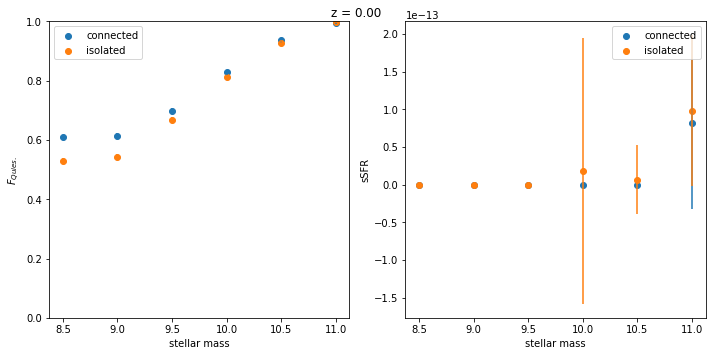

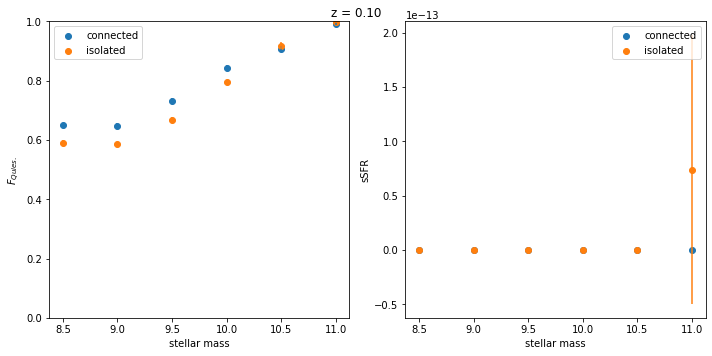

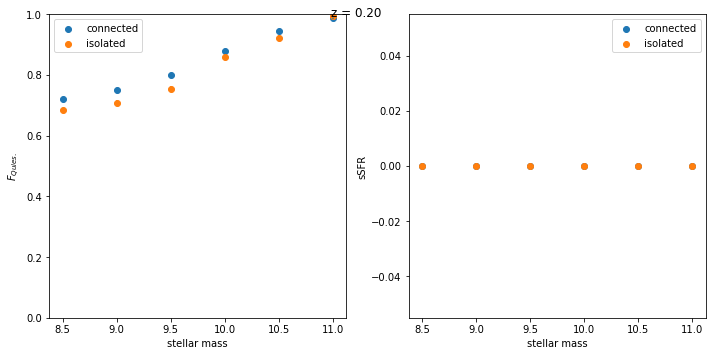

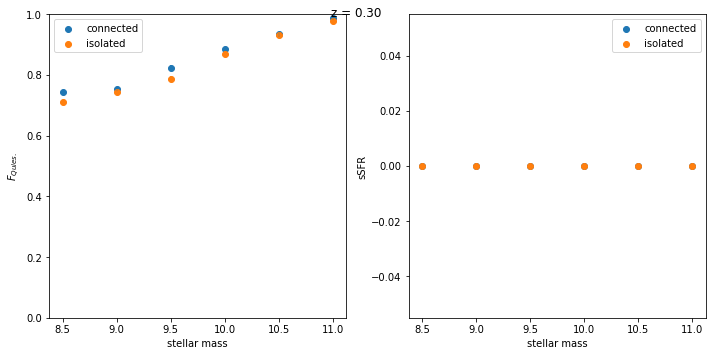

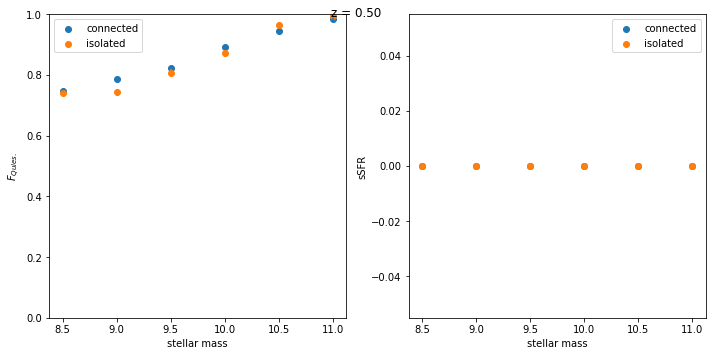

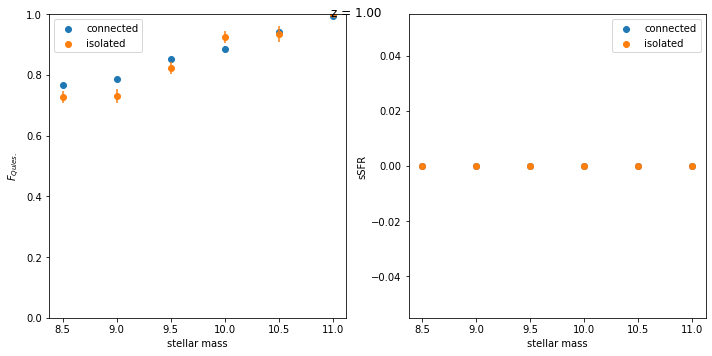

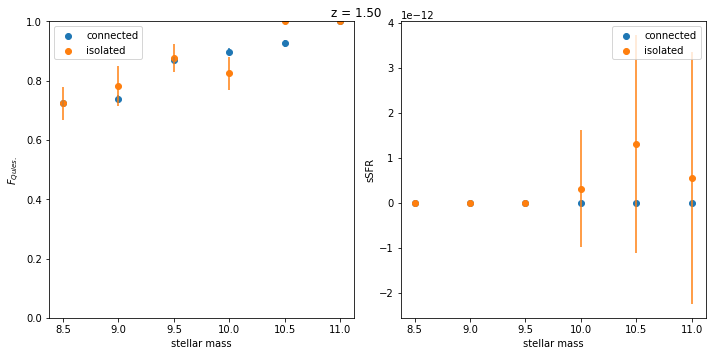

In [80]:
for isnap, snap in enumerate(snaps_full[:-1]):
    # isnap = np.where(snaps_full == snap)[0]

    scale_factor = scale_factors[isnap]
    z = zs_full[isnap]

    with h5py.File(f'./groups/grp_snap{snap}.hdf5', 'r') as f:
        #binning the grps in halo mass
        grp_m200 = f['Group_M_Crit200'][:] * 1e10 / 0.704
        grp_r200 = f['Group_R_Crit200'][:]
        grp_pos = f['GroupPos'][:]

    with h5py.File(f'./subhalos/subs_{snap}.hdf5', 'r') as f:
        MassInRad = f['SubhaloMassInRadType'][:, 4] * 1e10 / 0.704
        SubhaloGrNr = f['SubhaloGrNr'][:]
        SubhaloPos = f['SubhaloPos'][:]
        gal_mask = MassInRad >= 10**8.5

    halos = h5py.File(f'halo_structure_{snap:03d}.hdf5')


    with open(f'./lists_all/mem_ids_snap{snap:03d}', "rb") as f:
        mem_ids = pickle.load(f)

    with open(f'./lists_all/mem_ids_twice_snap{snap:03d}', "rb") as f:
        mem_ids_twice = pickle.load(f)

    with open(f'./lists_all/fofs_snap{snap:03d}', "rb") as f:
        fofs = pickle.load(f)

    with open(f'./lists_all/fqs_snap{snap:03d}', "rb") as f:
        fqs = pickle.load(f)

    with open(f'./lists_all/fqs_twice_snap{snap:03d}', "rb") as f:
        fqs_twice = pickle.load(f)

    with open(f'./lists_all/cpars_snap{snap:03d}', "rb") as f:
        cpars = pickle.load(f)

    #         mem_ids = np.array(mem_ids)
    fofs = np.array(fofs)
    fqs = np.array(fqs)
    fqs_twice = np.array(fqs_twice)
    cpars = np.array(cpars)

    num_mems = [len(x) for x in mem_ids]
    num_mems = np.array(num_mems)

    num_mems_twice = [len(x) for x in mem_ids_twice]
    num_mems_twice = np.array(num_mems_twice)

    grp_idx = np.where((grp_m200 >= 10**13) & (grp_m200 <= 10**15))[0]

    grp_idx_sorted = []

    for idx in grp_idx:

        ########### calculate FoF ###########
        center_pos = grp_pos[idx]

        if (center_pos[0] <= 10000) | (center_pos[0] >= (205000 - 10000)) | (center_pos[1] <= 10000 ) | (center_pos[1] >= (205000 - 10000) ) | (center_pos[2] <= 10000 ) | (center_pos[2] >= (205000 - 10000) ):
            continue

        grp_idx_sorted.append(idx)
    
    cparsmask = (cpars >= 0)
    hmmask = (grp_m200[grp_idx_sorted] >= 10**13) & (grp_m200[grp_idx_sorted] <= 10**13)
    isomask = fofs <= 0.06
    conmask = fofs > 0.06

    mem_ids = np.array(mem_ids)


    # calcualte
    fq_iso_med = []
    fq_iso_std = []
    fq_con_med = []
    fq_con_std = []

    ssfr_iso_med = []
    ssfr_iso_std = []
    ssfr_con_med = []
    ssfr_con_std = []

    sm_range = np.arange(8.5, 11.5, 0.5)

    for sm in sm_range:
        
        sm_id = np.where( (MassInRad >= 10**sm) & (MassInRad <= 10**(sm + 0.5)) )[0]
        
        ############ iso
        if np.any(cparsmask & hmmask & isomask):
        
            iso_id = np.concatenate(mem_ids[cparsmask & hmmask & isomask])

            mem_iso_mask = np.isin(sm_id, iso_id)

            isos = sm_id[mem_iso_mask]

            #iso
            fq_meds = []
            ssfr_meds = []

            for _ in range(100):

                boot = np.random.choice(isos, len(isos), replace = True)
                ssfrs = SFRs[f'Snapshot_{snap}']['SFR_MsunPerYrs_in_InRad_200Myrs'][:][boot] / (MassInRad[:][boot])
                quies_mask = ssfrs <= 1 / 3 / cosmo.age(z).to(u.yr).value

                fq = sum(quies_mask) / len(quies_mask)

                fq_meds.append(fq)
                ssfr_meds.append(np.median(ssfrs))

            fq_iso_med.append(np.mean(fq_meds))
            fq_iso_std.append(np.std(fq_meds))
            ssfr_iso_med.append(np.mean(ssfr_meds))
            ssfr_iso_std.append(np.std(ssfr_meds))
        
        else:
            fq_iso_med.append(np.nan)
            fq_iso_std.append(np.nan)
            ssfr_iso_med.append(np.nan)
            ssfr_iso_std.append(np.nan)

        ############ con
        if np.any(cparsmask & hmmask & conmask):
            
            con_id = np.concatenate(mem_ids[cparsmask & hmmask & conmask])
            
            mem_con_mask = np.isin(sm_id, con_id)
            
            cons = sm_id[mem_con_mask]
            
            fq_meds = []
            ssfr_meds = []

            for _ in range(100):

                boot = np.random.choice(cons, size = len(cons), replace = True)
                ssfrs = SFRs[f'Snapshot_{snap}']['SFR_MsunPerYrs_in_InRad_200Myrs'][:][boot] / (MassInRad[:][boot])
                quies_mask = ssfrs <= 1 / 3 / cosmo.age(z).to(u.yr).value

                fq = sum(quies_mask) / len(quies_mask)

                fq_meds.append(fq)
                ssfr_meds.append(np.median(ssfrs))

            fq_con_med.append(np.mean(fq_meds))
            fq_con_std.append(np.std(fq_meds))
            ssfr_con_med.append(np.mean(ssfr_meds))
            ssfr_con_std.append(np.std(ssfr_meds))
            
        else:
            fq_con_med.append(np.nan)
            fq_con_std.append(np.nan)
            ssfr_con_med.append(np.nan)
            ssfr_con_std.append(np.nan)

        print(len(isos), len(cons))
    
    fig, ax = plt.subplots(1, 2, figsize = (10, 5))
    # fig.subplots_adjust(wspace = 0)

    ax[0].scatter(sm_range, fq_con_med, label = 'connected')
    ax[0].errorbar(sm_range, fq_con_med, yerr = fq_con_std, linestyle = '')

    ax[0].scatter(sm_range, fq_iso_med, label = 'isolated')
    ax[0].errorbar(sm_range, fq_iso_med, yerr = fq_iso_std, linestyle = '')

    ax[0].legend()

    ax[0].set_xlabel('stellar mass')
    ax[0].set_ylabel(r'$F_{Quies.}$')
    
    ax[0].set_ylim(0, 1)
    
    ax[1].scatter(sm_range, ssfr_con_med, label = 'connected')
    ax[1].errorbar(sm_range, ssfr_con_med, yerr = ssfr_con_std, linestyle = '')

    ax[1].scatter(sm_range, ssfr_iso_med, label = 'isolated')
    ax[1].errorbar(sm_range, ssfr_iso_med, yerr = ssfr_iso_std, linestyle = '')

    ax[1].legend()

    # ax.set_yscale('log')
    ax[1].set_xlabel('stellar mass')
    ax[1].set_ylabel('sSFR')
    
    fig.tight_layout()
    fig.suptitle(f'z = {z:.2f}')
    
    print('\n')

In [79]:
# num_mems_twice

(array([ 64., 276., 330., 212.,  62.,  32.,   8.,   3.,   2.,   1.]),
 array([ 2.07483952,  3.3947159 ,  4.71459229,  6.03446867,  7.35434505,
         8.67422144,  9.99409782, 11.3139742 , 12.63385059, 13.95372697,
        15.27360335]),
 <BarContainer object of 10 artists>)

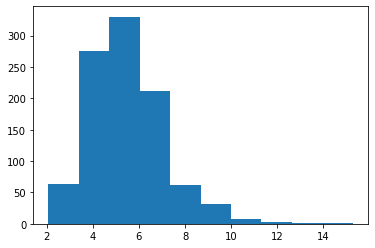

In [69]:
plt.hist(cpars)

(array([ 14., 150., 514., 719., 508., 293., 110.,  28.,   9.,   3.]),
 array([0.0233125 , 0.03384062, 0.04436875, 0.05489688, 0.065425  ,
        0.07595313, 0.08648125, 0.09700938, 0.1075375 , 0.11806563,
        0.12859375]),
 <BarContainer object of 10 artists>)

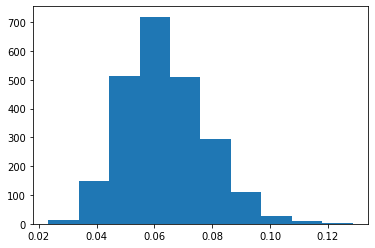

In [52]:
plt.hist(fofs)